### Imports and Data

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, learning_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TabularFeb2021/train.csv')

### Explore Data

In [ ]:
data.drop(columns=["id"],inplace=True)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cont0,300000.0,0.524634,0.204875,-0.093505,0.370451,0.492208,0.654793,1.052666
cont1,300000.0,0.506649,0.235269,-0.055105,0.352307,0.615156,0.688150,0.851746
cont2,300000.0,0.444115,0.200089,-0.060274,0.314121,0.457271,0.554835,1.017689
cont3,300000.0,0.446214,0.238669,0.134760,0.214572,0.377823,0.719758,1.006469
cont4,300000.0,0.455471,0.200695,0.189216,0.279853,0.411351,0.621808,0.994050
cont5,300000.0,0.508337,0.231612,-0.087247,0.338747,0.441384,0.709515,1.044433
cont6,300000.0,0.478345,0.192432,0.043953,0.339896,0.410090,0.604246,1.093312
cont7,300000.0,0.455904,0.204493,0.208703,0.278041,0.360736,0.639388,1.036541
cont8,300000.0,0.459321,0.220642,0.004041,0.308655,0.425801,0.541525,1.014156
cont9,300000.0,0.526899,0.204025,0.073040,0.361957,0.488867,0.752765,0.972091


In [ ]:
data.nunique()

cat0           2
cat1           2
cat2           2
cat3           4
cat4           4
cat5           4
cat6           8
cat7           8
cat8           7
cat9          15
cont0     299830
cont1     299642
cont2     299707
cont3     299796
cont4     299736
cont5     299857
cont6     299875
cont7     299832
cont8     299765
cont9     299863
cont10    299894
cont11    299877
cont12    299824
cont13    299866
target    299648
dtype: int64

In [ ]:
numeric_features = data.select_dtypes("float64").columns[:-1]
numeric_features

Index(['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object')

In [ ]:
categorical_features = data.select_dtypes("object").columns
categorical_features

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'],
      dtype='object')

### Standardize and normalize data

In [ ]:
data[numeric_features].apply(lambda x: (np.abs((x.max() / x.min())-1) * 100),axis=0)

cont0      1225.781442
cont1      1645.675958
cont2      1788.445950
cont3       646.860947
cont4       425.351211
cont5      1297.104206
cont6      2387.436951
cont7       396.658895
cont8     24994.238094
cont9      1230.903872
cont10     1626.538874
cont11     1517.876064
cont12    17267.343451
cont13      452.474971
dtype: float64

In [ ]:
data[numeric_features].apply(lambda x: ((x.std() / x.median())) * 100,axis=0)

cont0     41.623557
cont1     38.245481
cont2     43.757136
cont3     63.169476
cont4     48.789237
cont5     52.474048
cont6     46.924432
cont7     56.687698
cont8     51.817972
cont9     41.734250
cont10    38.770222
cont11    41.311555
cont12    54.224556
cont13    51.904391
dtype: float64

In [ ]:
data.isnull().mean()

cat0      0.0
cat1      0.0
cat2      0.0
cat3      0.0
cat4      0.0
cat5      0.0
cat6      0.0
cat7      0.0
cat8      0.0
cat9      0.0
cont0     0.0
cont1     0.0
cont2     0.0
cont3     0.0
cont4     0.0
cont5     0.0
cont6     0.0
cont7     0.0
cont8     0.0
cont9     0.0
cont10    0.0
cont11    0.0
cont12    0.0
cont13    0.0
target    0.0
dtype: float64

### Frequency Distribution

In [ ]:
for i in categorical_features:
    print(f'{i}\n{(np.round((data[i].value_counts() / len(data[i]))*100,3))}\n\n')

cat0
A    93.824
B     6.176
Name: cat0, dtype: float64


cat1
A    54.226
B    45.774
Name: cat1, dtype: float64


cat2
A    92.184
B     7.816
Name: cat2, dtype: float64


cat3
C    61.251
A    34.821
D     3.725
B     0.203
Name: cat3, dtype: float64


cat4
B    99.124
A     0.414
C     0.256
D     0.206
Name: cat4, dtype: float64


cat5
B    49.736
D    45.050
C     3.921
A     1.293
Name: cat5, dtype: float64


cat6
A    97.548
B     2.115
C     0.270
D     0.049
I     0.008
E     0.006
H     0.004
G     0.001
Name: cat6, dtype: float64


cat7
E    89.210
D     8.119
B     1.917
G     0.654
F     0.093
A     0.005
C     0.002
I     0.001
Name: cat7, dtype: float64


cat8
C    40.351
E    31.539
G    14.065
A    12.626
D     1.231
F     0.183
B     0.005
Name: cat8, dtype: float64


cat9
F    35.760
I    16.688
L    14.067
H     8.253
K     6.985
A     4.469
G     3.470
M     3.279
J     2.327
O     2.058
N     1.371
B     1.145
C     0.070
D     0.034
E     0.024
Name: cat9, dtype

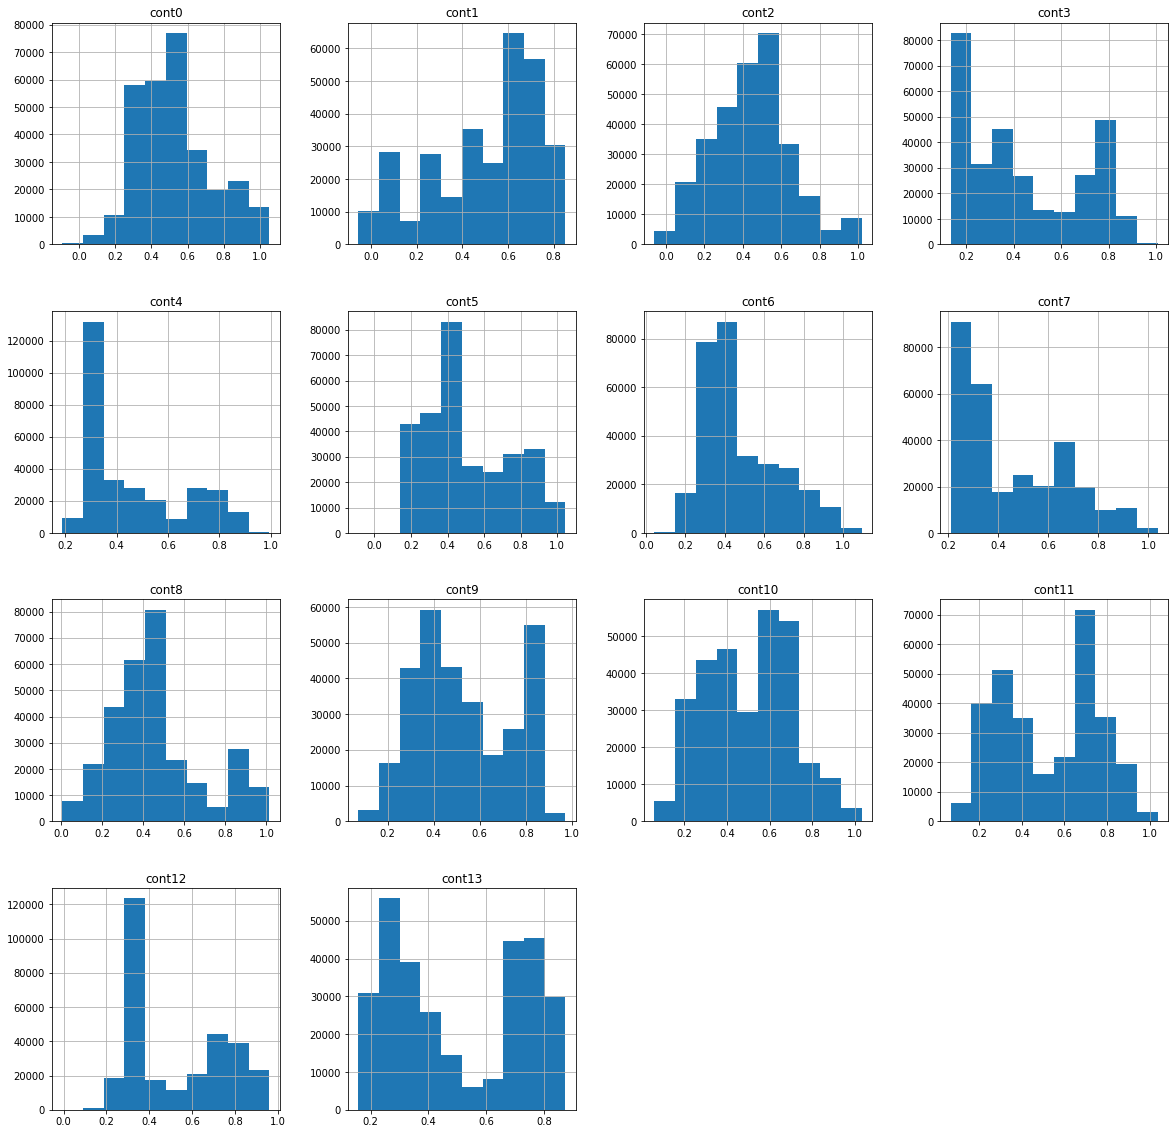

In [ ]:
data[numeric_features].hist(figsize=(20,20));

In [ ]:
for i in numeric_features:   
    print(f"Kolmogorov-Smirnov: {i} : {'Not Gaussian' if stats.kstest(data[i],'norm')[1]<0.05 else 'Gaussian'}")

Kolmogorov-Smirnov: cont0 : Not Gaussian
Kolmogorov-Smirnov: cont1 : Not Gaussian
Kolmogorov-Smirnov: cont2 : Not Gaussian
Kolmogorov-Smirnov: cont3 : Not Gaussian
Kolmogorov-Smirnov: cont4 : Not Gaussian
Kolmogorov-Smirnov: cont5 : Not Gaussian
Kolmogorov-Smirnov: cont6 : Not Gaussian
Kolmogorov-Smirnov: cont7 : Not Gaussian
Kolmogorov-Smirnov: cont8 : Not Gaussian
Kolmogorov-Smirnov: cont9 : Not Gaussian
Kolmogorov-Smirnov: cont10 : Not Gaussian
Kolmogorov-Smirnov: cont11 : Not Gaussian
Kolmogorov-Smirnov: cont12 : Not Gaussian
Kolmogorov-Smirnov: cont13 : Not Gaussian


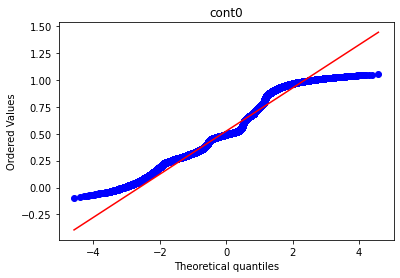

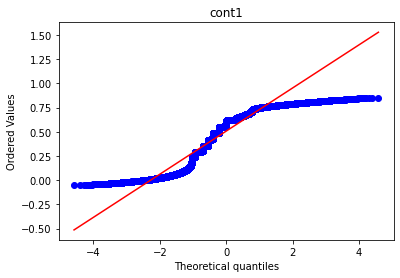

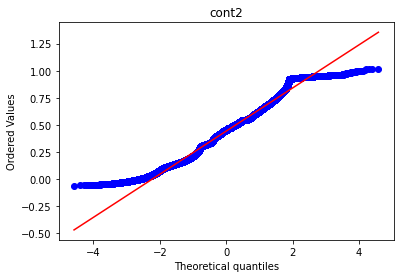

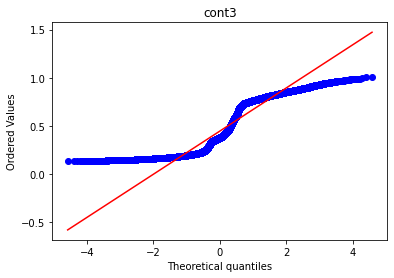

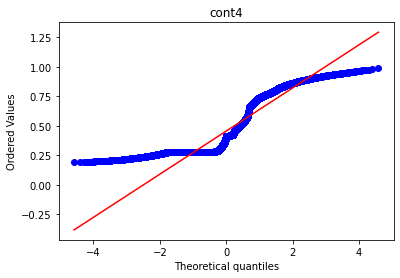

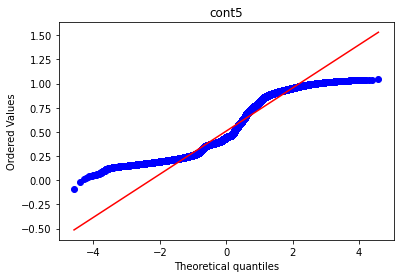

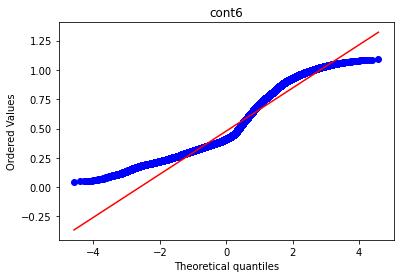

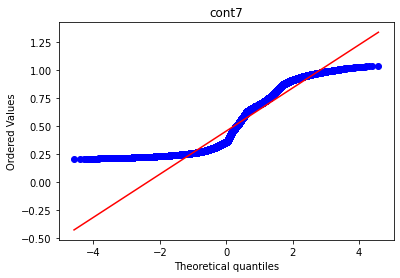

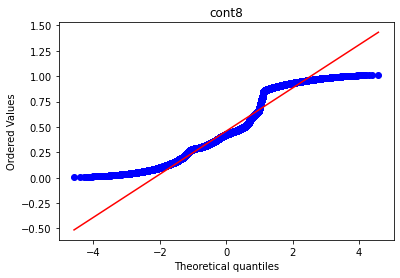

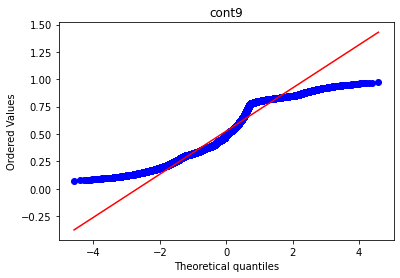

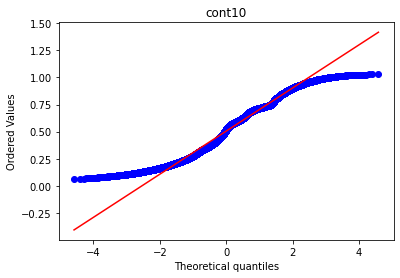

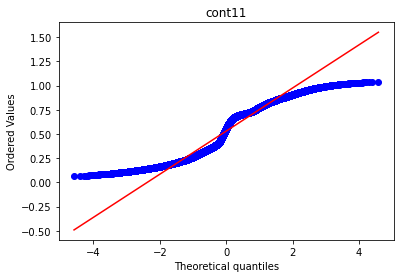

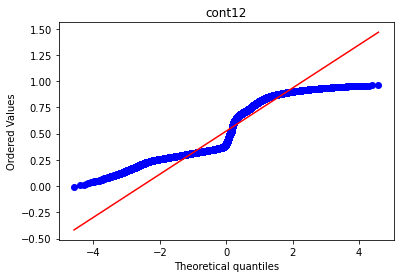

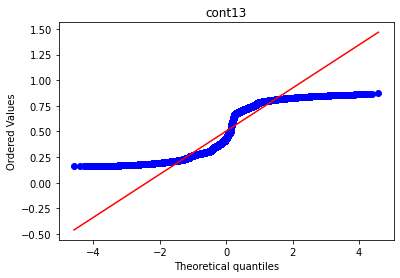

In [ ]:
for i in numeric_features:   
    stats.probplot(data[i],plot=plt)
    plt.title(i)
    plt.show()

### Outliers and Relationship with Target - Categorical Variables

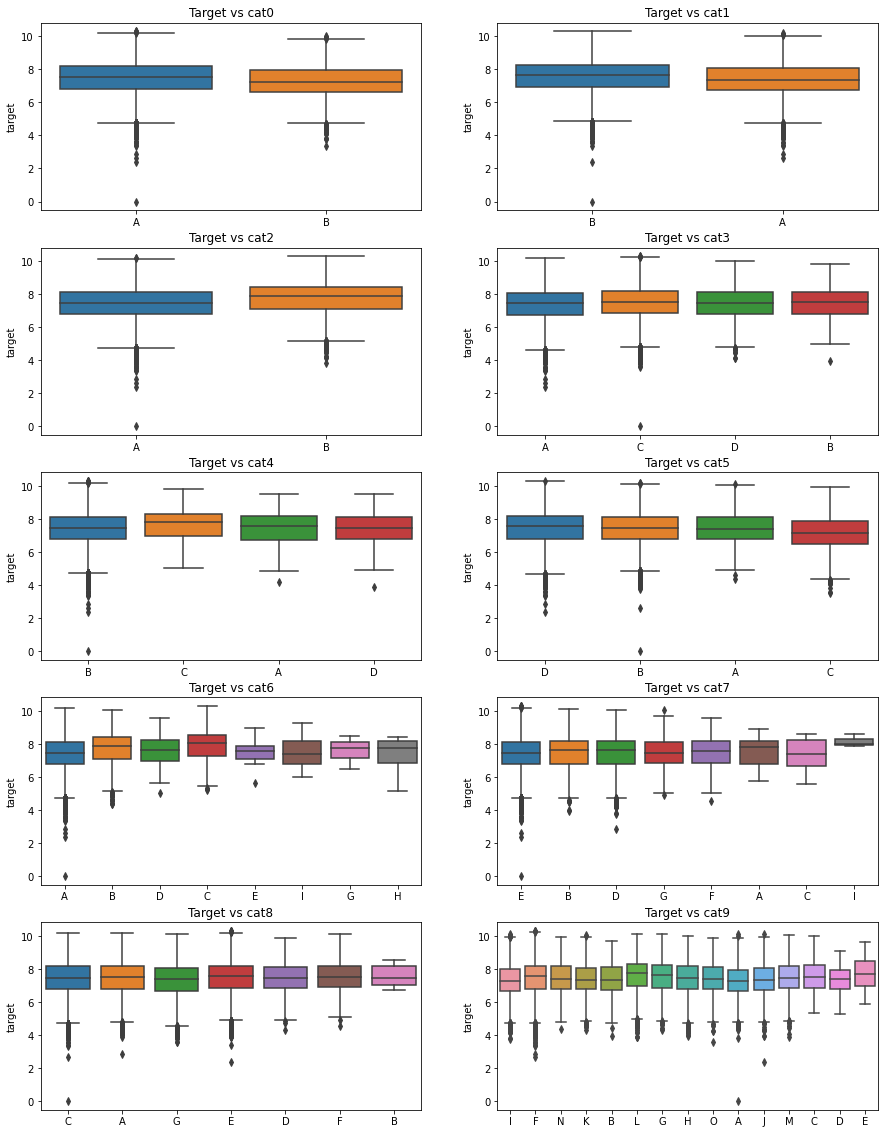

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(15,20),sharey=False)
row = col = 0
for n,i in enumerate(categorical_features):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    sns.boxplot(x=data[i],y=data['target'],ax=ax[row,col])
    ax[row,col].set_title(f"Target vs {i}")
    ax[row,col].set_xlabel("")
    col += 1
    
    
plt.show();

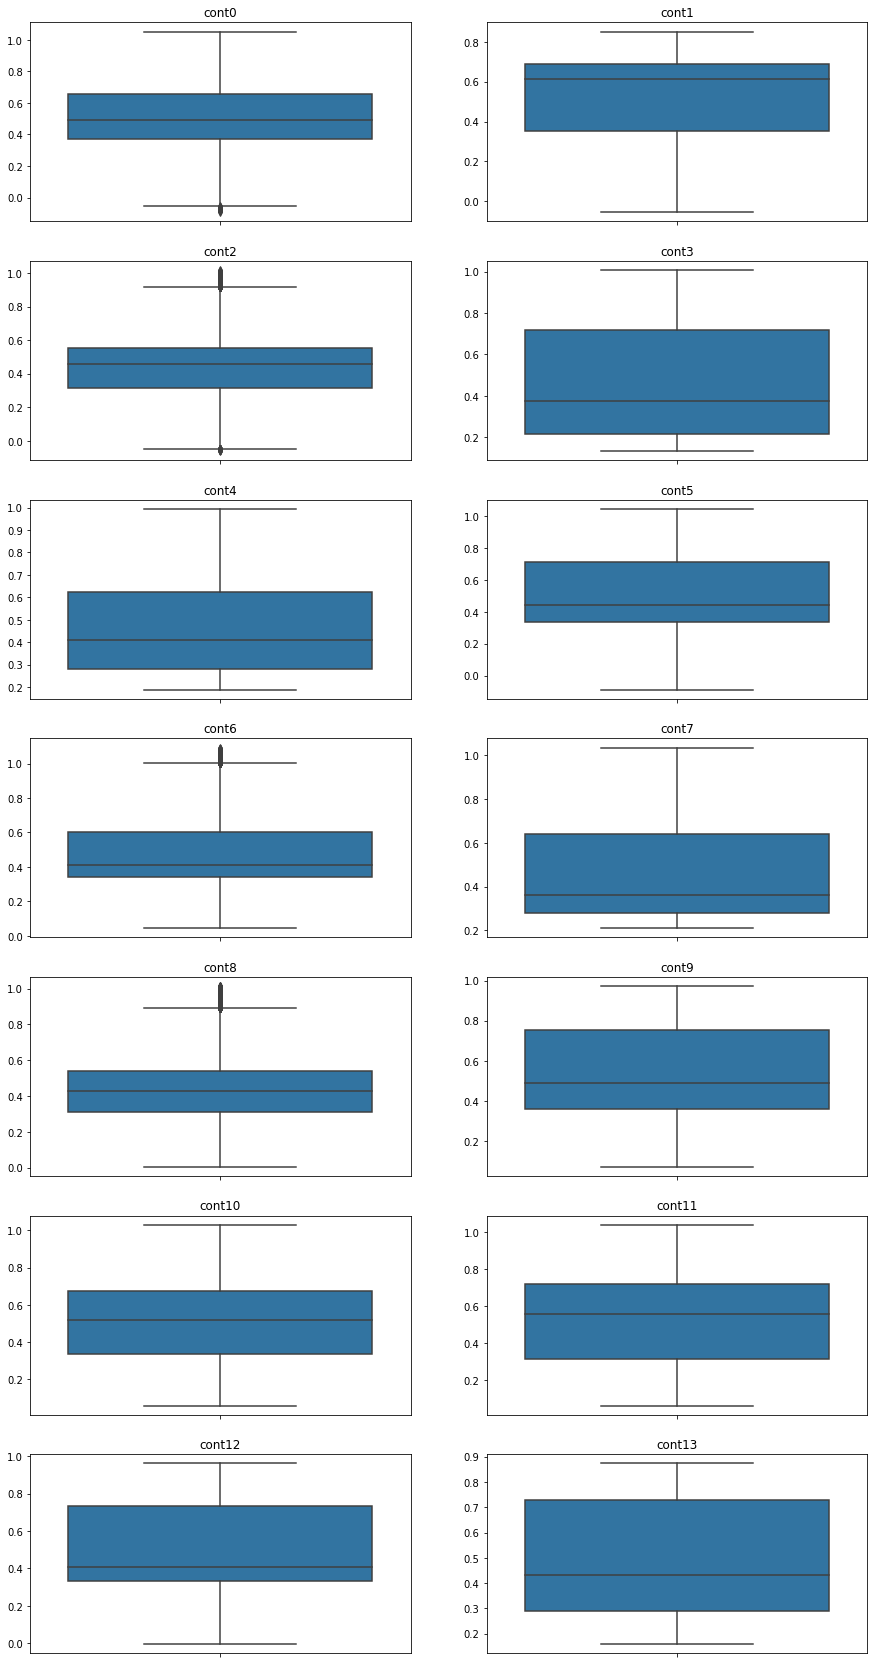

In [ ]:
fig,ax = plt.subplots(7,2,figsize=(15,30),sharey=False)
row = col = 0
for n,i in enumerate(numeric_features):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    sns.boxplot(y=data[i],ax=ax[row,col])
    ax[row,col].set_title(f"{i}")
    ax[row,col].set_ylabel("")
    col += 1
    
    
plt.show();

### Check for linear relationship / multicollinearity using Pearson, Kendall Coeffs and Scatterplots

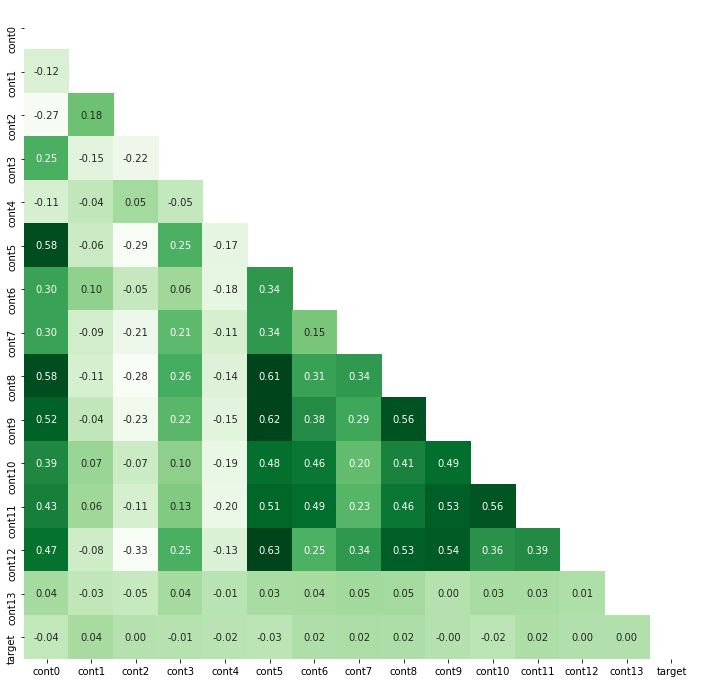

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),mask=np.triu(data.corr()),annot=True,cbar=False,fmt=".2f",robust=True, cmap = 'Greens');

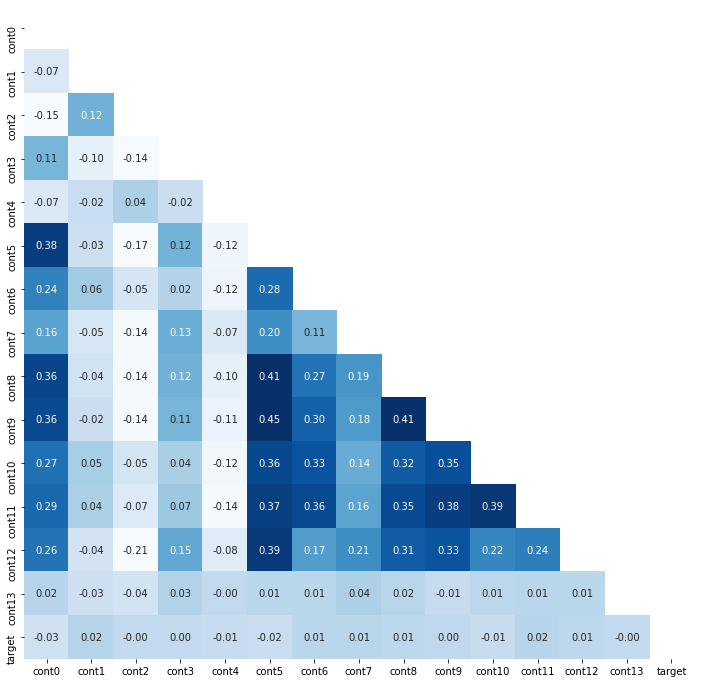

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(data.corr(method='kendall'),mask=np.triu(data.corr()),annot=True,cbar=False,fmt=".2f",robust=True, cmap = 'Blues');

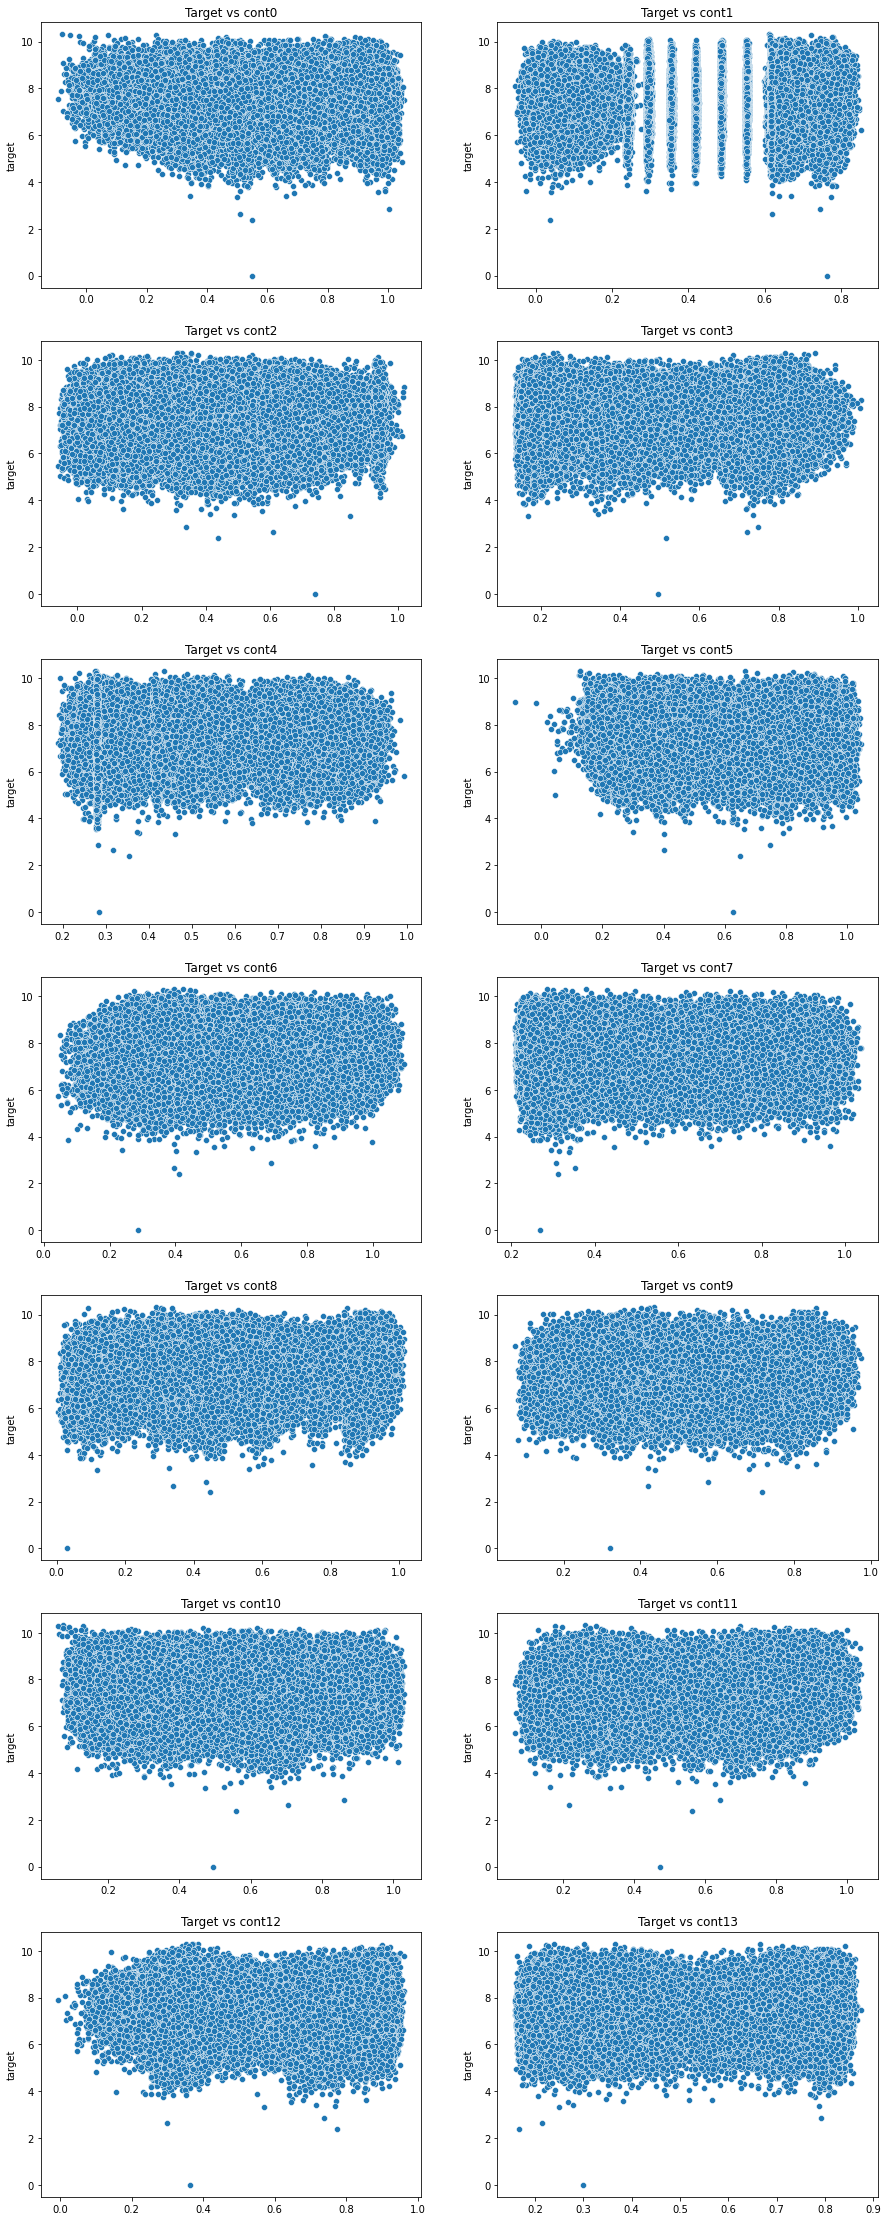

In [ ]:
fig,ax = plt.subplots(7,2,figsize=(15,40),sharey=False)
row = col = 0
for n,i in enumerate(numeric_features):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    sns.scatterplot(x=i,y='target',data=data,ax=ax[row,col])
    ax[row,col].set_title(f"Target vs {i}")
    ax[row,col].set_xlabel("")
    col += 1
    
    
plt.show();

### Recursively eliminating multicollinearity in numeric features

In [ ]:
X_vif  = data[numeric_features].copy()
vif =  [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

[13.527492073230032, 5.516661211353855, 5.505572395144323, 4.914195435247128, 5.155409066316589, 14.380500634638848, 10.129428148038519, 6.940743267019102, 10.782685358073671, 15.747502005159756, 12.534915283054366, 11.867065148644786, 12.36689548242551, 5.4074557032898385]


In [ ]:
flag = True
correlated_features_to_delete = []
while flag == True:
    vif =  pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])])
    if vif.max() >= 10:
        max_vif_col = pd.Series(X_vif.columns)[vif.argmax()]
        correlated_features_to_delete.append(max_vif_col)
        X_vif.drop(columns=max_vif_col,inplace=True)
    else:
        flag = False
correlated_features_to_delete

['cont9', 'cont5', 'cont0', 'cont10']

In [ ]:
vif =  [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

[5.459319196408897, 5.3841124663420965, 4.813064988196934, 5.070278270598525, 9.33538972221726, 6.815809848376833, 8.86403259077365, 9.939270273882952, 9.88343594529068, 5.373872574893945]


In [ ]:
multi_coll_features = pd.DataFrame({'feature':correlated_features_to_delete})

### Studying Target Variable

In [ ]:
data['target'].describe()

count    300000.000000
mean          7.456260
std           0.887295
min           0.000000
25%           6.798341
50%           7.496503
75%           8.161166
max          10.309208
Name: target, dtype: float64

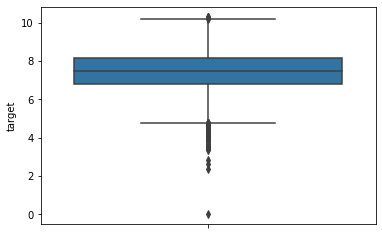

In [ ]:
sns.boxplot(y=data['target']);

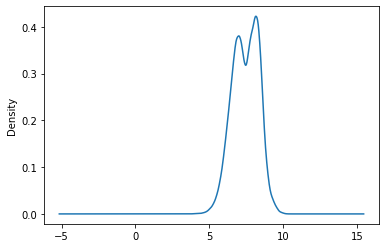

In [ ]:
data['target'].plot(kind="kde");

In [ ]:
data['target'].quantile(0.01)

5.405141653130049

In [ ]:
data['target'].quantile(0.995)

9.440493379423646

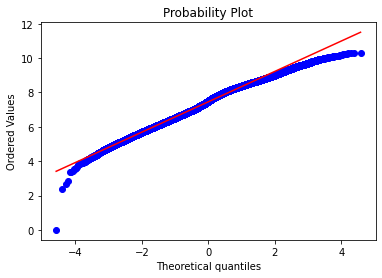

In [ ]:
stats.probplot(data['target'],plot=plt);

### Findings from EDA

EDA findings


1.   Box plots reveal relationship among few categorical variables and target variable.
2.   There exists multicollinearity among numeric variables.
3.   There are few categorical variables with rare labels.
4.   No numeric variable has Gaussian distribution.
5.   Few numeric variables have outliers
6.   There are no numeric variables with zero or near zero variance relative to median
7.   No strong relationship seen between numeric and target vaiables.


The above EDA shows that an extensive feature engineering is required for linear models to work on this data, since most of the assumptions like feature normality, non-multicollinearity, linear relationship b/w input features and target are not met. The relationship between the input features and target is also not looking strong and simple. Hence, trying non-linear models may be helpful. We'll build a baseline model with RandomForest.

Random Forest Model extremely overfits. So feature engineering is necessary.

### Feature Engineering

In [ ]:
non_rare = pd.DataFrame()
for i in categorical_features:
    var_dist = data[i].value_counts().copy()
    var_dist = (var_dist / var_dist.sum()).copy()
    non_rare = pd.concat([non_rare,pd.DataFrame({i:var_dist[var_dist>0.05].index})],axis=1).copy()

non_rare.to_csv('./non_rare_categories.csv',index=False)

In [ ]:
non_rare = pd.read_csv('./non_rare_categories.csv')
non_rare

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,A,A,A,C,B,B,A,E,C,F
1,B,B,B,A,NaN,D,NaN,D,E,I
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,L
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,H
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K


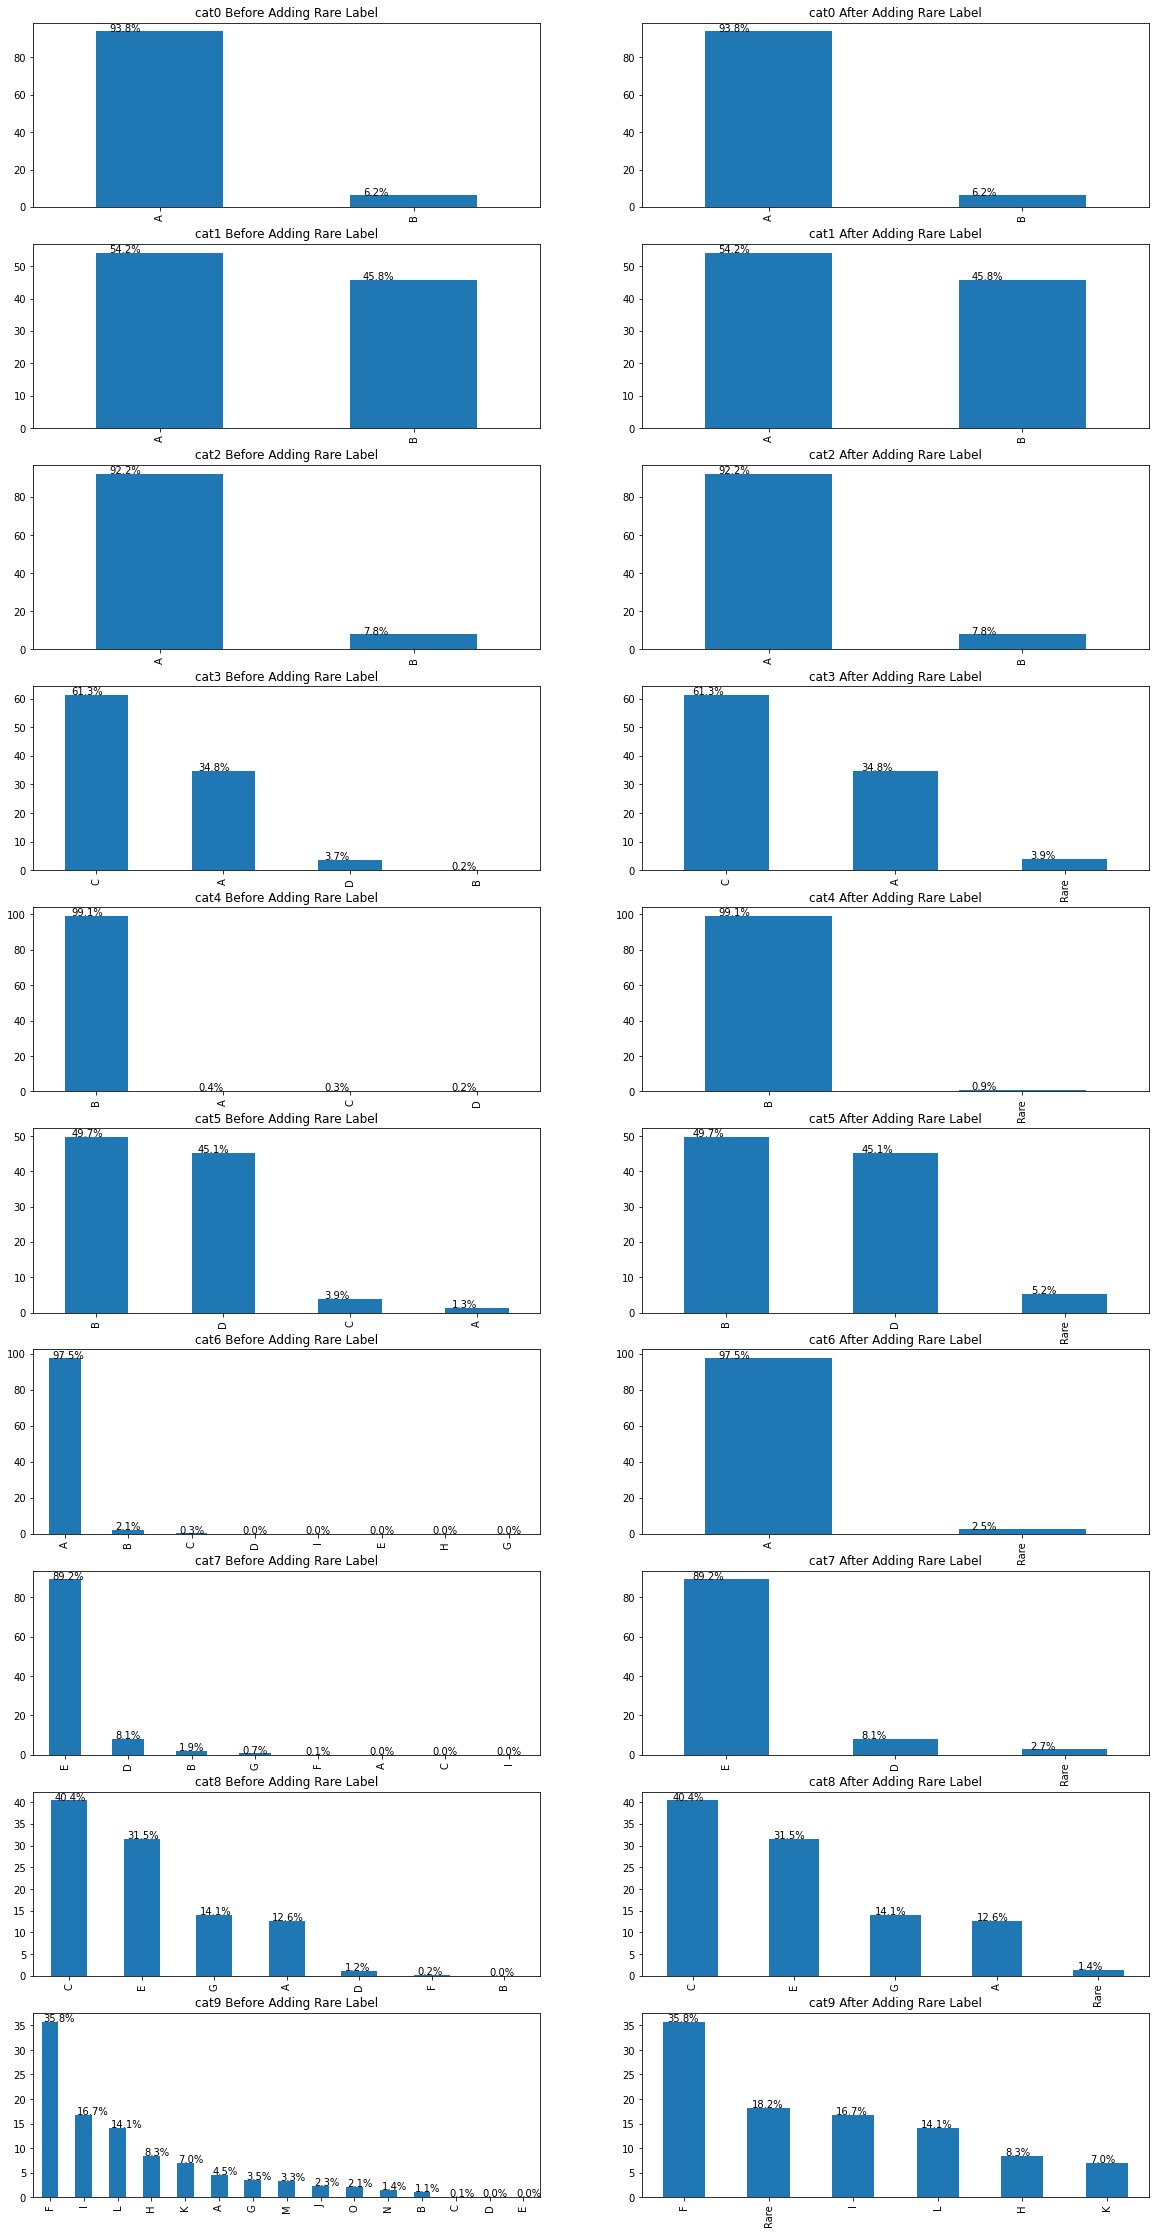

In [ ]:
new_data = data.copy()
for i in non_rare.columns:
    new_data.loc[(new_data[i].isin(non_rare[i]) == False), i] = "Rare"

fig,ax = plt.subplots(10,2,figsize=(20,40))
row = col = 0
for n,i in enumerate(non_rare.columns):
    cat_dist = data[i].value_counts().copy()
    cat_dist = np.round((cat_dist / cat_dist.sum()) * 100,1).copy()
    cat_dist.plot(kind="bar",ax=ax[row,0],sharey=False)
    ax[row,0].set_title(i + " Before Adding Rare Label")
    for n,j in enumerate(cat_dist.index):
        ax[row,0].text(x=n-0.2,y=cat_dist[j]+0.1,s=str(cat_dist[j]) + "%")
    
    
    new_cat_dist = new_data[i].value_counts().copy()
    new_cat_dist = np.round((new_cat_dist / new_cat_dist.sum()) * 100,1).copy()
    new_cat_dist.plot(kind="bar",ax=ax[row,1])
    ax[row,1].set_title(i + " After Adding Rare Label")
    for n,j in enumerate(new_cat_dist.index):
        ax[row,1].text(x=n-0.2,y=new_cat_dist[j]+0.1,s=str(new_cat_dist[j]) + "%")
    
    
    row += 1
plt.show()

No change in frequency distribution after combining rare labels. So it is a good way to go.

### Combining rare labels

In [ ]:
for i in non_rare.columns:
    data.loc[(data[i].isin(non_rare[i]) == False), i] = "Rare"

In [ ]:
X = data.drop(columns="target").copy()
y = data["target"].copy()

### Hyperparameter Tuning

In [ ]:
"""

ct = ColumnTransformer(transformers=[['oe',OrdinalEncoder(),categorical_features]],remainder='passthrough')
pipeline = Pipeline(steps=[['ord_encoder',ct],
                           ['rfe',RFE(estimator=xgb.XGBRegressor(tree_method='gpu_hist',random_state=11,n_jobs=-1))],
                           ['regressor',xgb.XGBRegressor(tree_method='gpu_hist',random_state=11,n_jobs=-1)]])
param_grid = {'rfe__n_features_to_select': range(8,21,2),
             'regressor__n_estimators':[200,500],
             'regressor__max_depth':[4,7,10,12],
             'regressor__reg_lambda':[0.01,0.1,1,10,100]}
gscv = GridSearchCV(estimator=pipeline,
                   param_grid=param_grid,
                   scoring="neg_root_mean_squared_error",
                   cv=2,
                   n_jobs=-1,
                   return_train_score=True,
                   verbose=11)
gscv.fit(X,y)
gscv.best_estimator_.get_params()

"""

'\n\nct = ColumnTransformer(transformers=[[\'oe\',OrdinalEncoder(),categorical_features]],remainder=\'passthrough\')\npipeline = Pipeline(steps=[[\'ord_encoder\',ct],\n                           [\'rfe\',RFE(estimator=xgb.XGBRegressor(tree_method=\'gpu_hist\',random_state=11,n_jobs=-1))],\n                           [\'regressor\',xgb.XGBRegressor(tree_method=\'gpu_hist\',random_state=11,n_jobs=-1)]])\nparam_grid = {\'rfe__n_features_to_select\': range(8,21,2),\n             \'regressor__n_estimators\':[200,500],\n             \'regressor__max_depth\':[4,7,10,12],\n             \'regressor__reg_lambda\':[0.01,0.1,1,10,100]}\ngscv = GridSearchCV(estimator=pipeline,\n                   param_grid=param_grid,\n                   scoring="neg_root_mean_squared_error",\n                   cv=2,\n                   n_jobs=-1,\n                   return_train_score=True,\n                   verbose=11)\ngscv.fit(X,y)\ngscv.best_estimator_.get_params()\n\n'

   XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
            importance_type='gain', interaction_constraints='',
            learning_rate=0.300000012, max_delta_step=0, max_depth=4,
            min_child_weight=1, missing=nan, monotone_constraints='()',
            n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=11,
            reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=1,
            tree_method='gpu_hist', validate_parameters=1, verbosity=None)]],

In [ ]:
"""
gscv.best_estimator_
"""

'\ngscv.best_estimator_\n'

Pipeline(steps=[('rfe', RFE(estimator=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=10... colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain', interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=1, tree_method='gpu_hist', validate_parameters=1, verbosity=None)]])

### Fitting the model with best hyperparameters

In [ ]:
ct = ColumnTransformer(transformers=[['oe',OrdinalEncoder(),categorical_features]],remainder='passthrough')
pipeline = Pipeline(steps=[['ord_encoder',ct],
                    ['rfe',RFE(estimator=xgb.XGBRegressor(tree_method='gpu_hist',random_state=11,n_jobs=-1), n_features_to_select=20)],
                    ['regressor',xgb.XGBRegressor(tree_method='gpu_hist',random_state=11,n_jobs=-1, max_depth=4,n_estimators=200,reg_lambda=100)]])
pipeline.fit(X,y)

[06:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ord_encoder',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[['oe',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'],
      dtype='object')]],
                                   verbose=False)),
                ('rfe',
                 RFE(e...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_ste

### Feature Selection

In [ ]:
features_after_oe = pd.Series(categorical_features)
features_after_oe = list(features_after_oe.append(pd.Series(list(X.columns))[pd.Series(list(X.columns)).isin(features_after_oe)==False]))
features_after_oe

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13']

In [ ]:
features_selected_rfe = []
for n,i in enumerate(features_after_oe):
    if pipeline["rfe"].support_[n] == True:
        features_selected_rfe.append(i)
        
    print(f'{i}: {pipeline["rfe"].support_[n]}')

cat0: True
cat1: True
cat2: True
cat3: True
cat4: False
cat5: True
cat6: True
cat7: False
cat8: True
cat9: True
cont0: True
cont1: True
cont2: False
cont3: True
cont4: False
cont5: True
cont6: True
cont7: True
cont8: True
cont9: True
cont10: True
cont11: True
cont12: True
cont13: True


In [ ]:
features_selected_rfe

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat5',
 'cat6',
 'cat8',
 'cat9',
 'cont0',
 'cont1',
 'cont3',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13']

In [ ]:
feat_imp = (pd.DataFrame(pipeline['regressor'].get_booster().get_score(importance_type="gain"),index=[0]).T).reset_index()
feat_imp['index'] = feat_imp['index'].str.replace('f',"").astype('int')
feat_imp.sort_values(by="index",inplace=True)
feat_imp['index'] = features_selected_rfe
feat_imp.sort_values(by=0,ascending=False,inplace=True)
feat_imp.columns = ["Feature","Imp"]
feat_imp

,Feature,Imp
1,cat2,142.308781
13,cat6,111.254690
0,cat1,99.182534
12,cat0,92.479886
8,cat3,70.110519
4,cat8,45.536471
18,cat9,42.176670
2,cont13,42.073204
3,cat5,38.216789
6,cont0,35.341633


In [ ]:
impdf001 = pd.DataFrame({'Feature':features_selected_rfe,'Imp':pipeline['regressor'].feature_importances_}).sort_values(by='Imp',ascending=False)
impdf001

,Feature,Imp
2,cat2,0.149432
5,cat6,0.116823
1,cat1,0.104147
0,cat0,0.097109
3,cat3,0.073620
6,cat8,0.047816
7,cat9,0.044288
19,cont13,0.044179
4,cat5,0.040130
8,cont0,0.037111


### New Features

In [ ]:
X = data.drop(columns="target").copy()
y = data["target"].copy()

In [ ]:
X['cat2p6'] = X['cat2'] + X['cat6']
X['cat6p1'] = X['cat6'] + X['cat1']
X['cat2p1'] = X['cat2'] + X['cat1']

X['cat2p0'] = X['cat2'] + X['cat0']
X['cat6p0'] = X['cat6'] + X['cat0']
X['cat1p0'] = X['cat1'] + X['cat0']

In [ ]:
new_categorical_features = list(categorical_features).copy()
new_categorical_features.extend(['cat2p6','cat6p1','cat2p1','cat2p0','cat6p0','cat1p0'])
new_categorical_features

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat2p6',
 'cat6p1',
 'cat2p1',
 'cat2p0',
 'cat6p0',
 'cat1p0']

### Fitting the model

In [ ]:
ct = ColumnTransformer(transformers=[['oe',OrdinalEncoder(),new_categorical_features]],remainder='passthrough')
pipeline = Pipeline(steps=[['ord_encoder',ct],
                    ['rfe',RFE(estimator=xgb.XGBRegressor(tree_method='gpu_hist',random_state=11,n_jobs=-1), n_features_to_select=22)],
                    ['regressor',xgb.XGBRegressor(tree_method='gpu_hist',random_state=11,n_jobs=-1, max_depth=4,n_estimators=200,reg_lambda=100)]])

In [ ]:
cv = cross_validate(estimator=pipeline,X=X,y=y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1,return_train_score=True)

In [ ]:
print(f"Training Scores (RMSE) : {cv['train_score'] *-1}")
print(f"Mean Training Score (RMSE) : {np.mean(cv['train_score'] *-1)}")
print("\n")
print(f"Test Scores (RMSE) : {cv['test_score'] *-1}")
print(f"Mean Test Score (RMSE) : {np.mean(cv['test_score'] *-1)}")

Training Scores (RMSE) : [0.84124775 0.84122063 0.84084063 0.84118775 0.84128605]
Mean Training Score (RMSE) : 0.8411565619915173


Test Scores (RMSE) : [0.84663749 0.84694777 0.84801128 0.84753749 0.84600937]
Mean Test Score (RMSE) : 0.8470286821368497


In [ ]:
pipeline.fit(X,y)

[06:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Pipeline(memory=None,
         steps=[('ord_encoder',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[['oe',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9', 'cat2p6', 'cat6p1',
                                                   'cat2p1', 'cat2p0', 'cat6p0',
                                                   'cat1p0'...
                              colsample_bylevel=1, colsample_bynode=1,

### Learning Curve

In [ ]:
train_size,train_scores,test_scores = learning_curve(estimator=pipeline,X=X,y=y,cv=5,scoring="neg_root_mean_squared_error",random_state=42)
train_scores = np.mean(-1*train_scores,axis=1)
test_scores = np.mean(-1*test_scores,axis=1)
lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")

[06:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

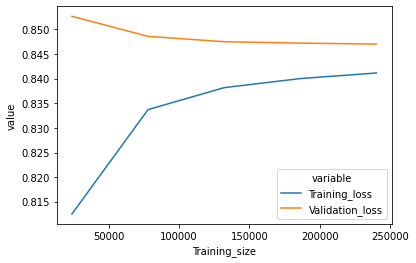

In [ ]:
sns.lineplot(data=lc,x="Training_size",y="value",hue="variable");

### Test Set Prep

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/TabularFeb2021/test.csv')

In [ ]:
test.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13'],
      dtype='object')

In [ ]:
test_ids = test["id"].copy()

In [ ]:
test.drop(columns="id",inplace=True)

In [ ]:
non_rare = pd.read_csv('./non_rare_categories.csv')

In [ ]:
for i in non_rare.columns:
    test.loc[(test[i].isin(non_rare[i]) == False), i] = "Rare"

In [ ]:
test['cat2p6'] = test['cat2'] + test['cat6']
test['cat6p1'] = test['cat6'] + test['cat1']
test['cat2p1'] = test['cat2'] + test['cat1']

test['cat2p0'] = test['cat2'] + test['cat0']
test['cat6p0'] = test['cat6'] + test['cat0']
test['cat1p0'] = test['cat1'] + test['cat0']

In [ ]:
test.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'cat2p6', 'cat6p1', 'cat2p1', 'cat2p0', 'cat6p0', 'cat1p0'],
      dtype='object')

### Predictions

In [ ]:
prediction = pipeline.predict(test)

In [ ]:
assert len(test_ids) == len(prediction)

In [ ]:
submission = pd.DataFrame({'id':test_ids,'target':prediction})

In [ ]:
submission.to_csv('/content/drive/MyDrive/TabularFeb2021/submission.csv',index=False)